In [13]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import operator as op
import ipynbname
import math
import time
from Functions.Utils import *
from Functions.RLS import *
from Functions.RTLO_R1 import *
from Functions.Graphs import *
from Functions.TEDA import *
from Functions.TedaGraphs import *
import optuna
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_pareto_front
from optuna.importance import get_param_importances
from optuna.samplers import RandomSampler
import os
import re
import sys
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib as mpl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import pickle
FileName = ipynbname.name()
K=0

dir_hi = r"C:\Artigo_J3C_V2\VMD10\HI"
dir_rs = r"C:\Artigo_J3C_V2\VMD10\RS6_def\S2_A1_Q10_W10_RS_raw\RS1"
brngs1 = ['Bearing1_1.csv','Bearing2_2.csv','Bearing1_2.csv','Bearing1_3.csv','Bearing2_5.csv']
Mp=[1.9249999999999998, 10, 8, True]

In [24]:
def objective(trial):
    m = trial.suggest_float('m', 1.4, 2.0,step=0.005)
    nRS = trial.suggest_int('nRS', 1, 15) 
    st = trial.suggest_int('st', 0, 10) 
    drop = trial.suggest_categorical('drop', [False, False]) 
    brngs = brngs1[0:3]
    vgrnls,ngrnls = np.array([]),np.array([])

    Grncreated = None
    lenRun=0

    for i,brng in enumerate(brngs):
        df_RS = (pd.read_csv(os.path.join(dir_rs,brng)).abs()).iloc[:,:-1]
        df_HI = (pd.read_csv(os.path.join(dir_hi,brng)).abs()).iloc[:,:-1]
        if drop: df_RS = df_RS.drop(columns='Y')
        xS = process_RS(df_RS, nRS)[st:]
        #RS, HI = process_input(df_RS,df_HI,nRS)
        #xS,yS,zS = RS[st:-1], HI[st:-1], HI[1+st:]

        if i==0: teda=AutoCloud(m=m, nS=len(xS[0]), nI=1, nR=1, nO=1, ηS=[1,1,1],
                            tau=1, decay=1, eol=0.3, fator=1) 
        elif i>0: teda.reset_rul()
        teda.add_rulR2(n=-(st+nRS)+len(df_RS))

        for j,_ in enumerate(xS):
            x= xS[j]
            teda.run(X=x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True,OfflineRun=True)
                
        #if i == 0: 
        Grncreated = len(teda.c)
        trial.report(Grncreated, step=j + lenRun)
        if trial.should_prune(): raise optuna.TrialPruned()

    for cloud in teda.c[:]:
        cloud.calc_Dmax(teda.xR,teda.xF)
        cloud.calc_v(k=teda.k)
        vgrnls = np.append(vgrnls,cloud.v*cloud.n)
        ngrnls = np.append(ngrnls,cloud.n)
    return np.sum(vgrnls)/np.sum(ngrnls)
K = K +1
pruner=optuna.pruners.ThresholdPruner(upper=6, lower=2)
study = optuna.create_study(
    direction="maximize",
    #storage="sqlite:///" + f'98_Optuna/{FileName}_Grnls.db',
    #study_name=f'P{7}',
    #sampler=RandomSampler(),
    pruner=pruner,
    load_if_exists=True)
study.optimize(objective, n_trials=500)
best_params = study.best_params
Mp = list(best_params.values())
print('Erro:', study.best_value, 'parameters: ', Mp)


[I 2026-02-25 15:46:59,914] A new study created in memory with name: no-name-e3f4b8e4-8fae-403a-a094-1575ffcc1f1e
[I 2026-02-25 15:46:59,947] Trial 0 pruned. 
c:\Users\claud\anaconda3\Lib\site-packages\optuna\trial\_trial.py:503: UserWarning:

The reported value is ignored because this `step` 149 is already reported.

[I 2026-02-25 15:47:00,001] Trial 1 finished with value: 0.24664734232028718 and parameters: {'m': 1.525, 'nRS': 7, 'st': 5, 'drop': False}. Best is trial 1 with value: 0.24664734232028718.
[I 2026-02-25 15:47:00,010] Trial 2 pruned. 
[I 2026-02-25 15:47:00,023] Trial 3 pruned. 
[I 2026-02-25 15:47:00,030] Trial 4 pruned. 
[I 2026-02-25 15:47:00,037] Trial 5 pruned. 
[I 2026-02-25 15:47:00,054] Trial 6 pruned. 
c:\Users\claud\anaconda3\Lib\site-packages\optuna\trial\_trial.py:503: UserWarning:

The reported value is ignored because this `step` 156 is already reported.

[I 2026-02-25 15:47:00,089] Trial 7 finished with value: 0.4259219047771925 and parameters: {'m': 1.7149

Erro: 0.8905410335316873 parameters:  [1.585, 2, 5, False]


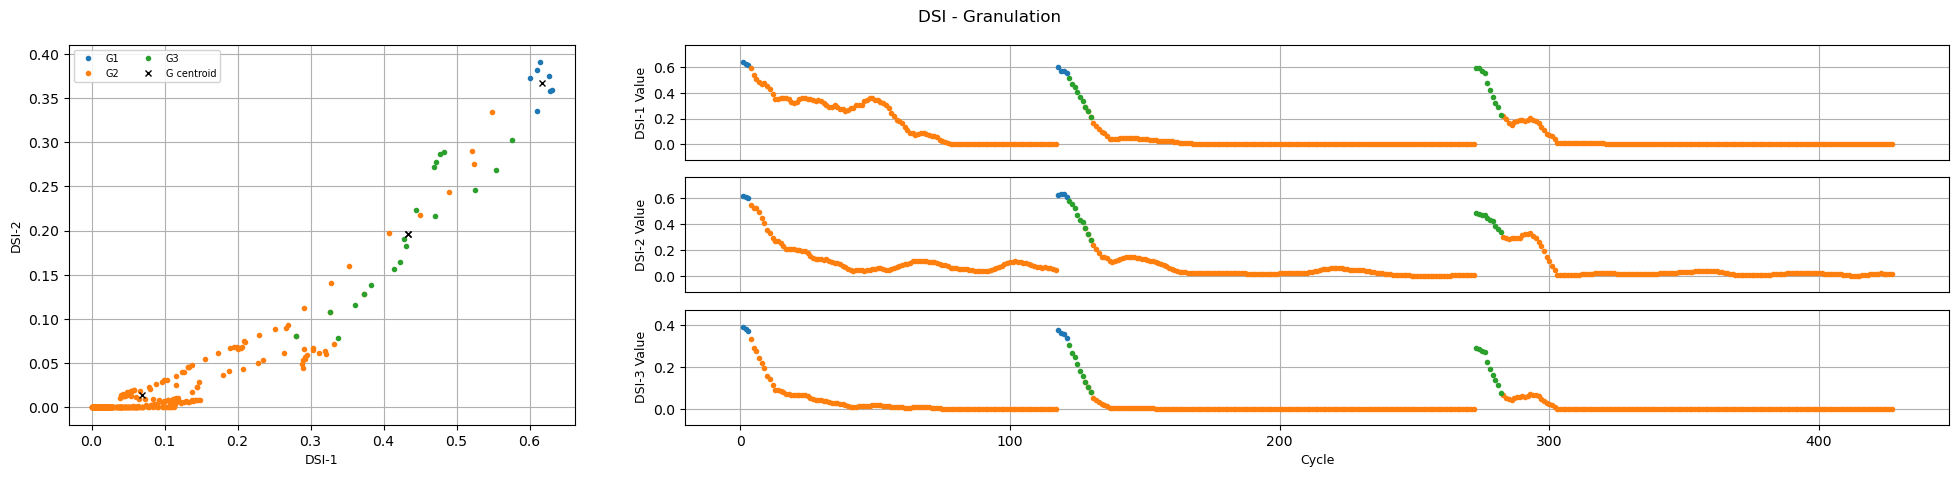

In [25]:
m, nRS, st, drop= Mp
for i,brng in enumerate(brngs1[:3]):
    df_RS = (pd.read_csv(os.path.join(dir_rs,brng)).abs()).iloc[:,:-1]
    df_HI = (pd.read_csv(os.path.join(dir_hi,brng)).abs()).iloc[:,:1]
    if drop: df_RS = df_RS.drop(columns='Y')
    xS = process_RS(df_RS, nRS)[st:]

    if i==0: teda=AutoCloud(m=m, nS=len(xS[0])) 
    elif i>0: teda.reset_rul()
    teda.add_rulR2(n=-(st+nRS)+len(df_RS))

    for j,_ in enumerate(xS):
        x = xS[j]
        if i <= 1: teda.run(X=x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True,OfflineRun=True)
        else: teda.run(x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True, OfflineRun=True)
    if i==1:
        teda.OffineGrnls = [cloud for cloud in teda.c]

    for cloud in teda.c[:]:
        cloud.calc_Dmax(teda.xR,teda.xF)
        cloud.calc_v(k=teda.k)

vgrnls,ngrnls = np.array([]),np.array([])

for cloud in teda.c[:]:
    cloud.calc_Dmax(teda.xR,teda.xF)
    cloud.calc_v(k=teda.k)
    vgrnls = np.append(vgrnls,cloud.v*cloud.n)
    ngrnls = np.append(ngrnls,cloud.n)
#print(np.sum(vgrnls)/np.sum(ngrnls))
plot_DSI2(teda,ftrs=3,title='DSI - Granulation',ncol=2,w=20,h=5)


In [26]:
def objective(trial):
    m, nRS, st, drop= Mp
    init = (st+nRS)
    nHI = trial.suggest_int('nHI', 1, init) 
    nR = trial.suggest_int('nR', 1, 30) 
    #N1 = trial.suggest_float('N1', 8e-4, 6e-3, log=True)
    #N2 = trial.suggest_float('N2', 4e-4, 1e-2, log=True)
    #N3 = trial.suggest_float('N3', 1e-14, 1e-6, log=True)
    #N1 = trial.suggest_float('N1', 1e-10, 1e-2, log=True)
    #N2 = trial.suggest_float('N2', 1e-10, 1e-2, log=True)
    #N3 = trial.suggest_float('N3', 1e-10, 1e-2, log=True)
    #decay = trial.suggest_float('decay', 1e-10, 1e-0, log=True)

    N1 = trial.suggest_categorical('N1', [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]) 
    N2 = trial.suggest_categorical('N2', [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]) 
    N3 = trial.suggest_categorical('N3', [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]) 
    D = trial.suggest_categorical('D', [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])
    tau = trial.suggest_int('tau', 1, 30)
    #fator = trial.suggest_float('fator', 0.95, 1.05, step=0.01)
    erro = np.array([])
    brngs = brngs1[0:1]
    len_ = 0
    for i,brng in enumerate(brngs):
        mapeInit,check = None, False
        df_RS = (pd.read_csv(os.path.join(dir_rs,brng)).abs()).iloc[:,:-1]
        df_HI = (pd.read_csv(os.path.join(dir_hi,brng)).abs()).iloc[:,-1:]
        if drop: df_RS = df_RS.drop(columns='Y')
        xS = process_RS(df_RS, nRS)[st:]
        RS = process_RS(df_RS,nRS)
        HI = process_HI(df_HI,nHI=nHI,init=init)
        xS,yS,zS = RS[st:-2], HI[:-1], HI[1:]

        if i==0: 
            teda=AutoCloud(m=m, nS=len(xS[0]), nI=len(yS[0]), nR=nR, nO=len(yS[0]), 
                            ηS=[N1,N2,N3], tau=tau, decay=D,
                            eol=0.2, fator=1,st=st+nRS-1) 
        elif i>0: teda.reset_rul()
        teda.win_all=True
        teda.add_rulR2(n=-(st+nRS)+len(df_RS))

        for j,_ in enumerate(xS):
            x,y,z= xS[j],yS[j],zS[j]
            teda.run(X=x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True,OfflineRun=True)
            teda.adapt(y,z)
            teda.RUL_single(y, Scut=150)

            if i ==0:
                if np.any(1 != teda.cloud_activation2[-1]) and not check:
                    mapeInit=j
                    check = True
                    DamagedGrnl = (teda.cloud_activation2[-1])
            elif i>0 and not check:
                if DamagedGrnl in teda.cloud_activation3[-1]:
                    mapeInit = j+0
                    check = True

            if j == int(len(xS)*0.25):  # checkpoint de avaliação
                trial.report(teda.rulP[-1], step=j+len_)
                if trial.should_prune():
                    raise optuna.TrialPruned()

        #print(lGrnl)
        mape = teda.MAPE(start=mapeInit,rulR=teda.rulR2)
        erro = np.append(erro,mape)
        len_ = len_ + len(df_RS)
    MAPE = np.mean(erro)
    return MAPE

K = K +1
pruner=optuna.pruners.ThresholdPruner(upper=160, lower=2)
sampler = optuna.samplers.TPESampler(multivariate=True,group=True,seed=1,n_startup_trials=1000)
#sampler=RandomSampler()
study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///" + f'Optuna/{FileName}_Prdct.db',
    study_name=f'P{2}',
    sampler=sampler,
    pruner=pruner,
    load_if_exists=True)
study.optimize(objective, n_trials=5000)
best_params = study.best_params
Mp2 = list(best_params.values())
print('Erro:', study.best_value, 'parameters: ', Mp2)


c:\Users\claud\anaconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.

c:\Users\claud\anaconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning:

Argument ``group`` is an experimental feature. The interface can change in the future.

[I 2026-02-25 15:48:20,643] A new study created in RDB with name: P2
[I 2026-02-25 15:48:20,884] Trial 0 finished with value: 1.100211941461551 and parameters: {'nHI': 3, 'nR': 22, 'N1': 0.1, 'N2': 0.1, 'N3': 1e-07, 'D': 0.01, 'tau': 24}. Best is trial 0 with value: 1.100211941461551.
[I 2026-02-25 15:48:21,007] Trial 1 pruned. 
[I 2026-02-25 15:48:21,097] Trial 2 pruned. 
[I 2026-02-25 15:48:21,146] Trial 3 pruned. 
[I 2026-02-25 15:48:21,212] Trial 4 finished with value: 0.9488373747396022 and parameters: {'nHI': 5, 'nR': 8, 'N1': 0.001, 'N2': 0.001, 'N3': 1e-08, 'D': 1e-07, 'tau': 1}. Best is trial 4 with value: 0.948837

Erro: 0.24968866197315107 parameters:  [3, 1, 0.1, 1e-05, 0.01, 1e-09, 17]


In [27]:
plot_parallel_coordinate(study)

In [32]:
nHI, nR, N1, N2, N3,D, tau = Mp2
init = (st+nRS)
len_=0
for i,brng in enumerate(brngs1[:2]):
    mapeInit,check = None, False
    df_RS = (pd.read_csv(os.path.join(dir_rs,brng)).abs()).iloc[:,:-1]
    df_HI = (pd.read_csv(os.path.join(dir_hi,brng)).abs()).iloc[:,-1:]
    if drop: df_RS = df_RS.drop(columns='Y')
    RS = process_RS(df_RS,nRS)
    HI = process_HI(df_HI,nHI=nHI,init=init)
    xS,yS,zS = RS[st:-2], HI[:-1], HI[1:]
    if i==0: 
        teda=AutoCloud(m=m, nS=len(xS[0]), nI=len(yS[0]), nR=nR, nO=len(yS[0]), 
                            ηS= [N1, N2, N3], tau=tau, decay=D,
                            eol=0.2, fator=1,st=st+nRS-1) 
    elif i>0: teda.reset_rul()
    teda.win_all = True
    teda.add_rulR2(n=-(st+nRS)+len(df_RS))
    for j,_ in enumerate(xS):
        x,y,z= xS[j],yS[j],zS[j]
        teda.run(X=x,MergeGrnls=True,MergeOffGrnls=True,FitOffGrnls=True,OfflineRun=True)
        teda.adapt(y,z)
        teda.RUL_single(y)

        if i ==0:
            if np.any(1 != teda.cloud_activation2[-1]) and not check:
                mapeInit=j
                check = True
                DamagedGrnl = (teda.cloud_activation2[-1])
        elif i>0 and not check:
            if DamagedGrnl in teda.cloud_activation3[-1]:
                mapeInit = j + 0
                check = True

    mape2 = teda.MAPE(start=mapeInit,rulR=teda.rulR2)
    check = False
    print(mape2,mapeInit)
    plot_2series(x1=teda.cycleP,x2=teda.cycleP,y1=teda.rulR2,y2=teda.rulP, title=brng,s1='True',s2='Pred')
#plot_DSI2(teda,ftrs=3,title='DSI - Granulation',ncol=2)


0.24968866197315107 3


0.47091224410409716 10
